In [7]:
import Ouzo_Graph_Tools as ouzo_graphs
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import numpy as np
from scipy import interpolate, stats

In [8]:
def extract_plates(path, sheet_list):
    """Will return a sublist of plates absorbance information in dataframe format
    Must ensure that excel sheet has only the samples made in the csv plan as will cause errors downstream."""
    plate_dfs = []
    for sheet_name in sheet_list:
        plate_df = pd.read_excel(path, sheet_name = sheet_name).T
        plate_dfs.append(plate_df)
    return plate_dfs

In [9]:
def merge_wavelength_dfs(df_list):
    merge_list = []
    for i, df in enumerate(df_list):
        if i == 0:
            df = df
        else: 
            df = df.drop(['Wavelength'])
        merge_list.append(df)
    return pd.concat(merge_list)

In [10]:
def baseline_correction(df_samples, baseline_series): 
    """Given the series iloc of a the blank, subtracts the value at every wavelength of blank at resp. wavelength. 
    Simple subtraction blanking."""
    new_df_con = []
    for key, row in df_samples.iterrows():
        if key == 'Wavelength':
            wavelengths = row
            new_df_con.append(wavelengths)
        else: 
            series = row
            corrected = series.subtract(baseline_series)
            new_df_con.append(corrected)
    
    baseline_corrected_df = pd.concat(new_df_con, axis = 1).T
    baseline_corrected_df.index = df_samples[0].index
    return baseline_corrected_df

In [11]:
def add_abs_to_sample_info(sample_info_df, abs_df):
    
    wavelengths = list(abs_df.loc['Wavelength'])
    wavelengths_names = [str(wavelength)+'nm' for wavelength in wavelengths]
    abs_df.columns = wavelengths_names
    
    
    sample_info_df.reset_index(drop=True, inplace=True)
    abs_df.reset_index(drop=True, inplace=True)
    combined_df = pd.concat([sample_info, abs_df], axis = 1)
    return combined_df

In [12]:
def remove_visual_outliers(x, y, z, z_score_threshold = 3):
    """This is not a to remove statistical outliers, only to remove values which present. Outliers will be 
    removed based on the data of z and subsequently from x and y given the same indexes of entries. Inputs must be nparrays"""

    z_array = np.asarray(z)
    z_scores = np.abs(stats.zscore(np.asarray(z)))
    threshold = z_score_threshold
    index_to_remove = np.where(z_scores > threshold)[0] # must be in ascending order
    
    x = x.copy()
    y = y.copy()
    z = z.copy()
    
    for index in reversed(index_to_remove): # reveresed to perserve index
        del x[index]
        del y[index]
        del z[index]
    
    xyz_array = [x,y,z]
    return xyz_array


In [13]:
# what happens with overflow or undefined data???

In [18]:
# Load all things needed in this case
sample_info = pd.read_csv(r"C:\Users\Edwin\Desktop\12_2_2020\experiment_info") # make it find the blank position from sample_info
plate_names = ['Sheet1','Sheet2']
plate_dfs = extract_plates(r"C:\Users\Edwin\Desktop\12_2_2020\12_02_20.xlsx", plate_names) # can edit/remove wells accidently measured etc, but really should be done at excel level
merged_df = merge_wavelength_dfs(plate_dfs)

In [19]:
# baseline and combine
baseline_series = merged_df.iloc[-1]
merged_baselined_df = baseline_correction(merged_df, baseline_series)
combined_df = add_abs_to_sample_info(sample_info, merged_baselined_df)
combined_df = combined_df[0:136]

In [20]:
# extract data by dict method of df calling series
wavelength = '600.0nm'
x_name = combined_df['Component 1 wtf'][0]
y_name = combined_df['Component 2 wtf'][0]
x = [float(i) for i in combined_df['Component 1 wtf'][1:].tolist()][:-1]
y = [float(i) for i in combined_df['Component 2 wtf'][1:].tolist()][:-1] # removes name of component from list
z = [float(i) for i in combined_df[wavelength][1:].tolist()][:-1]
combined_restricted_xyz = [x,y,z]
modi = remove_visual_outliers(x,y,z,10) # this should only be used to find the new vmin and vmax but not to exclude

In [21]:
print(len(modi[2]))

134


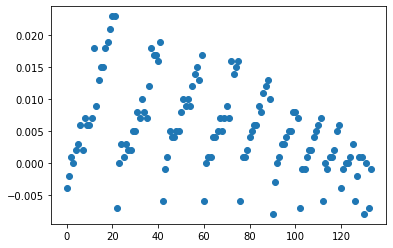

In [22]:
plt.scatter(range(len(modi[2])), modi[2])

In [23]:
min_x = min(combined_restricted_xyz[0])
max_x = max(combined_restricted_xyz[0])
min_y = min(combined_restricted_xyz[1])
max_y = max(combined_restricted_xyz[1])
min_z = min(modi[2])
max_z = max(modi[2])
# print(max_z)

In [66]:

### First make the xx,yy coordinates that the interpolation will span
x_space = np.linspace(min_x,max_x,100)  
y_space = np.linspace(min_y,max_y,100)
xx, yy = np.meshgrid(x_space,y_space) 

### Next make tuple the x,y data so it can be fed into interpolation method to make the interpolation mesh

cartcoord = list(zip(combined_restricted_xyz[0],combined_restricted_xyz[1]))
interp = interpolate.LinearNDInterpolator(cartcoord, combined_restricted_xyz[2])
Z0 = interp(xx,yy)


cartcoord_v = list(zip(modi[0],modi[1]))
interp_v= interpolate.interp2d(cartcoord_v, modi[2])
Z0_v = interp(xx,yy) # does not work as still interpolates far out and makes a v_max that is the same as z0??


# Finally, create the plot. 
# Note: Mappable for the interpolation is independent of the scatter colormap (which is created automatically), they are the same when you do not restrict either.
# Restriction is defined once you restrict the x/y space of the mesh to a space smaller than that of the scatter plot. 

fig, ax = plt.subplots()
vmin = np.nanmin(Z0_v) # so this is will ensure all the interpolations will fit on the colorbar
vmax = np.nanmax(Z0_v)

# norm=colors.Normalize(vmin=min_z, vmax=max_z) # but you can manually use your dat which is the most import to plot to find the range excl outliers
norm=colors.Normalize(vmin=min_z, vmax=max_z)

mappable = ax.pcolormesh(xx, yy, Z0, norm=norm)
# mappable.set_clim(vmin=vmin, vmax=vmax)
# mappable.set_clim(vmin,vmax)


ax.scatter(combined_restricted_xyz[0], combined_restricted_xyz[1], 
           c = combined_restricted_xyz[2], norm=norm, cmap = mpl.cm.viridis, edgecolors='k')

cbar = plt.colorbar(mappable)

cbar_txt = "AU at wavelength " + str(wavelength) + 'nm'
cbar.set_label(cbar_txt, labelpad = 10)
# ax.set_xlim(xmin =0, xmax = 0.0006) # simple ratios for easy viewing
ax.set_ylim([0.00005,0.0004])
ax.set_xlim([-0.00004,.0007])
# ax.set_yticks(np.arange(-0.0001, 0.00035, 0.0001))
# ax.set_yticks(np.arange(0, 0.0007, 0.00005))
# ax.set_xticks(np.arange(0, 0.00035, 0.001))
# axacx.yticks(np.arange(min, max, step))
ax.set_xlabel(x_name)
ax.set_ylabel(y_name)
# ax.set_xlim([-0.0001,0.0006])
# ax.text(0.4,0.002, "vmin = " + str(vmin) + '\nvmax = '+ str(vmax))

# ax.text(0.4,0.002,'*Negative AU values due to \n instrument resolution of 0.001 AU')
# ax.set_ylim([0,0.05])

# - when plotting in order to get hold of centered zeros just make very small incraments of negative vlaues. 

TypeError: __init__() missing 1 required positional argument: 'z'

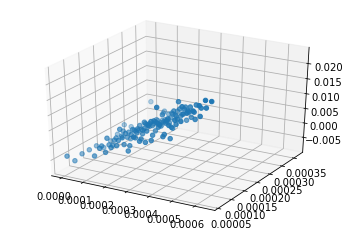

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = combined_restricted_xyz[0]
ys = combined_restricted_xyz[1]
zs = combined_restricted_xyz[2]
ax.scatter(xs, ys, zs)

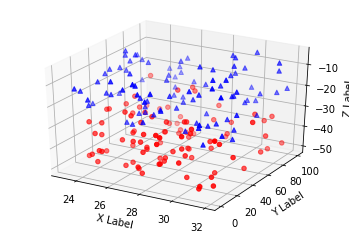

In [37]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<Figure size 432x288 with 0 Axes>

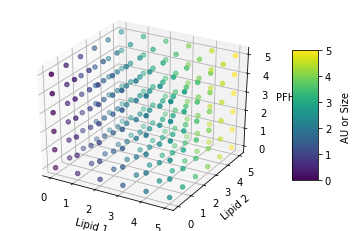

In [65]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def fn(x, y):
    """Custom fuction to determine the colour (potential?) of the point"""
    return (x + y) / 2  # use average as a placeholder

plt.tight_layout()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 6# range 0 to 10
# Make the 3D grid
X, Y, Z = np.meshgrid(np.arange(0, size, 1),
                      np.arange(0, size, 1),
                      np.arange(0, size, 1))

# calculate a colour for point(x,y,z)
zs = np.array([fn(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
ZZ = zs.reshape(X.shape)  # this is used below

# create the surface
xx, yy = np.meshgrid(np.arange(0, size, 1), np.arange(0, size, 1))
# Calcule the surface Z value, e.g. average of  the colours calculated above
zzs = np.array([np.average(ZZ[x][y]) for x, y in zip(np.ravel(xx), np.ravel(yy))])
zz= zzs.reshape(xx.shape)

cube = ax.scatter(X, Y, Z, zdir='z', c=zs)
# surf = ax.plot_surface(xx, yy, zz, cmap=plt.cm.rainbow) 
cbar = fig.colorbar(cube, shrink=0.6, aspect=5) # Add a color bar
cbar_txt = "AU or Size "
cbar.set_label(cbar_txt, labelpad = 10)
ax.set_xlabel('Lipid 1')
ax.set_ylabel('Lipid 2')
ax.set_zlabel('PFH')
plt.show()

